In [2]:
from qutip import *
import numpy as np
import scipy
import cmath
import matplotlib
import matplotlib.pyplot as plt
import itertools
from numpy.random import seed
from numpy.random import rand
from itertools import product
from scipy.misc import derivative
from scipy import optimize
from functools import wraps
from time import time
from matplotlib import rc
plt.style.use('seaborn')


In [3]:
#Wrapper to time functions
def timing(f):
    @wraps(f)
    def wrap(*args, **kw):
        ti = time()
        result = f(*args, **kw)
        tf = time()
        t = tf-ti
        return result, t
    return wrap

In [4]:
#Make basis and get sz values
def operatorCreation(N):
    #operator definitionis
    si = qeye(2)
    sx = 0.5*sigmax()
    sy = 0.5*sigmay()
    sz = 0.5*sigmaz()

    sx_list = []
    sy_list = []
    sz_list = []
    

    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(si)

        op_list[n] = sx
        sx_list.append(tensor(op_list))

        op_list[n] = sy
        sy_list.append(tensor(op_list))

        op_list[n] = sz
        sz_list.append(tensor(op_list))
        
        op_list[n] = si
    id = tensor(op_list)
        
    return sx_list, sy_list, sz_list,id

In [5]:
#Construct Hamiltonian
def hamiltonian(N,B,A0):
    sx_list = operatorCreation(N)[0]
    sy_list = operatorCreation(N)[1]
    sz_list = operatorCreation(N)[2]
    H = B*sz_list[0] 
    for n in range(N-1):
        H += A0*sz_list[0]*sz_list[n+1] + A0*sx_list[0]*sx_list[n+1] + A0*sy_list[0]*sy_list[n+1]
    return H

In [6]:
#Get Ground State Energy and Wavefuntion
class GroundState:
    
    def __init__(self, N, B, A0):
        self.hamiltonian = hamiltonian(N, B, A0)
     
    @timing
    def __call__(self):
        #find ground state
        H = self.hamiltonian
        groundState= H.groundstate()
        return groundState[0],groundState[1]

In [7]:
#Make basis and get sz values
def basisCreation(N):
    sz_list = operatorCreation(N)[2]
    Sbasis = []
    basisState = []
   
    for j in range(2):
        basisState.append(basis(2,j))
    b = itertools.product(basisState,repeat=N)
    basisTensor = list(b)
    #makes Sbasis the correct dimesion of Qobj
    for i in range(2**N):
        c = basisTensor[i][0]
        for j in range(N-1):
            c = tensor(c,basisTensor[i][j+1])
        Sbasis.append(c)

    
    #get sz values for basis states
    sz = np.zeros((2**N,N), dtype = complex)
    a = [[1 for j in range(N)] for i in range(2**N)]
    for i in range(2**N):
        for j in range(N):
            #matrix element <bra|Sz|ket>
            sz[i][j] = sz_list[j].matrix_element(Sbasis[i],Sbasis[i])
    return Sbasis, sz


In [12]:
#get randomized RBM parameters (between zero and 1)
def ranRBMpar(N,M):
    par = np.random.rand(2*(N+M+N*M))
    return par
a = ranRBMpar(2,2)
print(a)

[0.28777534 0.13002857 0.01936696 0.67883553 0.21162812 0.26554666
 0.49157316 0.05336255 0.57411761 0.14672857 0.58930554 0.69975836
 0.10233443 0.41405599 0.69440016 0.41417927]


In [11]:
#Function to give RBM wavefuntion
def RBM_ansatz(par,N, M):
    Sbasis = basisCreation(N)[0]
    sz = basisCreation(N)[1]
    #make parmeters complex
    num = N+M+N*M
    parC = np.vectorize(complex)(par[:num],par[num:])
    a = parC[:N]
    b = parC[N:N+M]
    W = parC[N+M:].reshape(M,N)
    expTerm = np.zeros(2**N, dtype = complex)
    coshTerm = np.zeros((M,2**N), dtype = complex)
    hidProduct = np.zeros(2**N, dtype = complex)
    psiMValues = np.zeros(2**N, dtype = complex)
    psiM = 0*Sbasis[0]

    for i in range(2**N):
        for m in range(M):
            coshTerm[m][i] = 2*np.cosh(np.dot(W[m],sz[i]) + b[m])
    hidProduct = np.prod(coshTerm, axis = 0) 
    
    for i in range(2**N):
        expTerm[i] = np.exp(np.dot(a,sz[i]))
        psiMValues[i] = expTerm[i]*hidProduct[i]
        psiM += psiMValues[i]*Sbasis[i]
    psiNorm = psiM.unit()
    return psiNorm

In [9]:
#Variation Energy Definition
def varEnergy(par,N, M, H):
    psiM = RBM_ansatz(par,N, M)
    E = expect(H,psiM)
    norm = psiM.norm()**2
    Enorm = E/norm
    return Enorm

In [10]:
#Energy Partials
def gradEnergy(par,N, M,H):
    eps = 0.001
    return optimize.approx_fprime(par,varEnergy,eps, N, M,H)

In [79]:
class GradDescent:
    def __init__(self, N, _B, _A0):
        self.hamiltonian = hamiltonian(N, _B, _A0)
    
    def __call__(self, N, M):
        par = ranRBMpar(N,M)
        H = self.hamiltonian
        min = scipy.optimize.fmin_cg(varEnergy,par,args= (N,M,H), gtol=1e-03, full_output=True, retall = True, disp=True)
        #Ground State
        found_gs = RBM_ansatz(min[0],N, M)
        found_gs = found_gs.unit()
        #Ground State Energy
        found_gsEnergy =varEnergy(min[0], N, M,H)

        return min, found_gs, found_gsEnergy  
    
    

In [74]:
#Error Calculation
def err(found_gs,gs,found_gsEnergy,gsEnergy):
    engErr = np.abs(found_gsEnergy-gsEnergy)
    waveFunctionErr = found_gs.dag()*gs
    waveFunctionErr = 1-waveFunctionErr.norm()
    
    return engErr,waveFunctionErr



In [67]:
#Vary M Values
N=2
M_values = np.arange(1,2)
results = []
B=0
A0=1

gradDescent = GradDescent(N, B, A0)

for i in range(M_values.size):
    r = gradDescent(N, M_values[i])
    results.append(r)

Optimization terminated successfully.
         Current function value: -0.249958
         Iterations: 2
         Function evaluations: 108
         Gradient evaluations: 9


In [68]:
gs = groundState( hamiltonian(2, B, A0))[1]
eng_err = []
waveFunction_err = []
for i in range(M_values.size):
    eng_err.append(err(results[i][1],gs,results[i][2],-0.75)[0])
    waveFunction_err.append(err(results[i][1],gs,results[i][2],-0.75)[1])

TypeError: __call__() takes 1 positional argument but 2 were given

In [ ]:
fig, ax1 = plt.subplots()
ttl =plt.suptitle("Effect of Number of Hidden Nodes (M) on \nEnergy and Wavefuntion Error",size =15)
ttl.set_position([.5, 1.05])
color = 'tab:red'
ax1.set_xlabel('M Value')
ax1.set_ylabel('Energy Error', color=color)
ax1.plot(M_values, eng_err,color=color)
ax1.scatter(M_values, eng_err, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Wavefunction Error', color=color)  
ax2.plot(M_values, waveFunction_err,'--', color=color)
ax2.scatter(M_values, waveFunction_err, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout() 
plt.show()


In [13]:
#Parameter Definition
N = 2
M = 2
A0 = 1 
B = 1

gradDescent = GradDescent(N, B, A0)

results = gradDescent(N,M)


NameError: name 'GradDescent' is not defined

In [89]:
#Get ground state error at each iteration
state = []
stateErr = []
engErr = []
groundState = GroundState(N,B,A0)
gs = groundState()[0][1]
gsEng = groundState()[0][0]

for i in range(len(results[0][5])):
    stateIter = RBM_ansatz(results[0][5][i],N, M)
    state.append(stateIter)
    EngIter = varEnergy(results[0][5][i],N, M, hamiltonian(N, B, A0))
    errIter = err(stateIter,gs,EngIter,gsEng)
    engErr.append(errIter[0])
    stateErr.append(errIter[1])

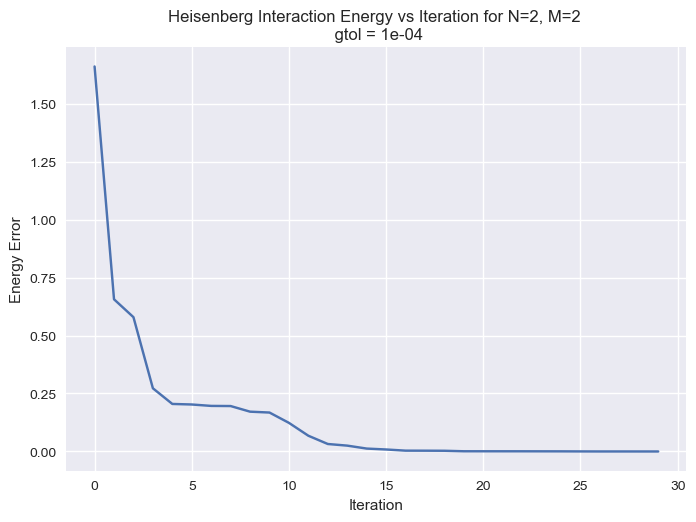

In [90]:
#plot energy vs iteration
numIter = len(results[0][5])
iter = np.arange(numIter)
plt.plot(iter, engErr)
plt.xlabel('Iteration')
plt.ylabel('Energy Error')
plt.title('Heisenberg Interaction Energy vs Iteration for N=2, M=2 \n gtol = 1e-04')
plt.show()

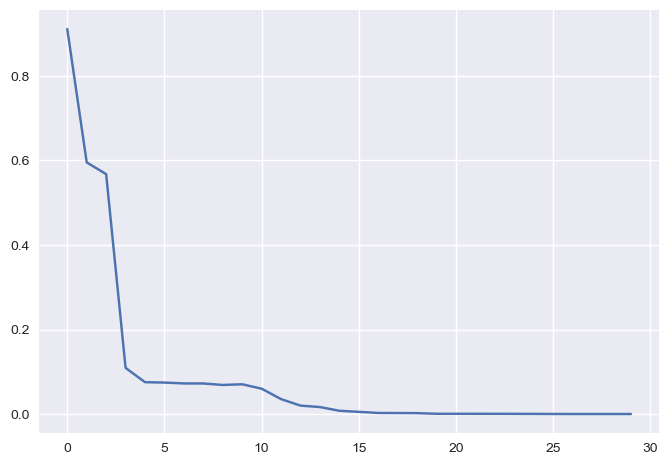

In [91]:
#Print Ground State Error
plt.plot(iter, stateErr)
plt.savefig('nakedplot.png', dpi=300)
#plt.title('Heisenberg Interaction Ground State Error vs Iteration for N=2, M=2')
plt.show()